In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import flwr as fl
import matplotlib.pyplot as plt
import numpy as np 
from typing import List, Tuple
from flwr.common import Metrics
import ray
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()

2024-02-13 20:32:09.959968: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 20:32:09.984912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 20:32:09.984937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 20:32:09.985643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 20:32:09.989884: I tensorflow/core/platform/cpu_feature_guar

# Data Processing

In [2]:
def getMnistData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'mnist',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [3]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255 

In [4]:
trainset,testset, info = getMnistData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)


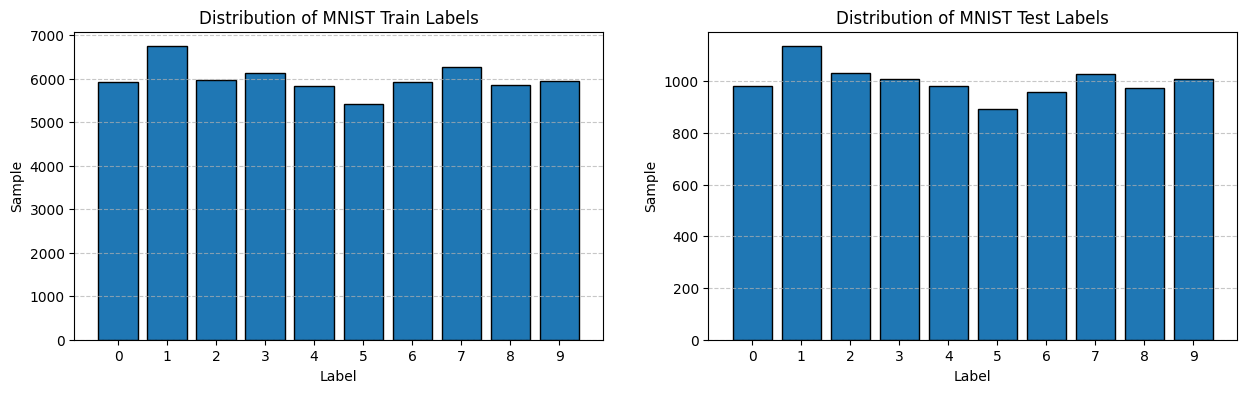

In [5]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of MNIST Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of MNIST Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [6]:
def split_into_partition(data, labels, num_partitions):
    # Combine data and labels
    combined_data = list(zip(data, labels))
    np.random.shuffle(combined_data)  # Shuffle the combined data randomly

    partitions = [[] for _ in range(num_partitions)]
    store_label = np.unique(labels).tolist()
    counter = 0
    count = 0
    # Iterate over unique labels to efficiently distribute them across partitions
    while store_label:
        random_choice = np.random.choice(store_label)

        # Extract data and labels for the selected class
        class_data = [item[0] for item in combined_data if item[1] == random_choice]
        class_labels = [random_choice] * len(class_data)

        # Distribute the class data evenly among partitions
        modnum = len(np.unique(labels)) // num_partitions

        if counter == (num_partitions - 1):
            partitions[counter].extend(list(zip(class_data, class_labels)))
        elif count <= modnum:
            # Extend the selected partition with the data and labels
            count+=1
            partitions[counter].extend(list(zip(class_data, class_labels)))
            if count == modnum:
                counter += 1
                count=0


        store_label.remove(random_choice)

   # Separate data and labels after partitioning
    data_partitions = [np.array(list(zip(*partition))[0]) if partition else np.array([]) for partition in partitions]
    label_partitions = [np.array(list(zip(*partition))[1]) if partition else np.array([]) for partition in partitions]


    return data_partitions, label_partitions

In [7]:
NumOfPartition = 2
train_image_part,train_label_part = split_into_partition(Train_images_n,Train_label,NumOfPartition)

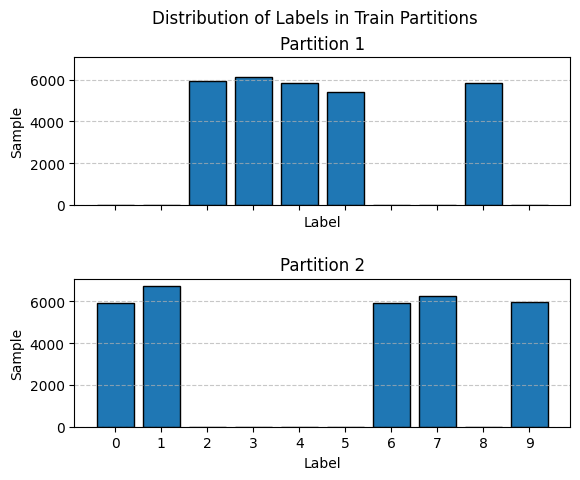

In [8]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

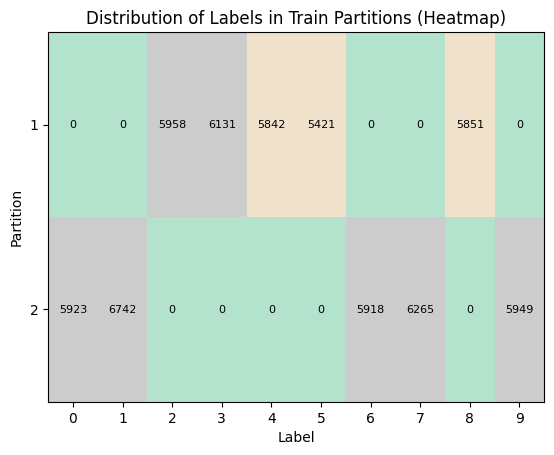

In [9]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [10]:
def customCNNModel():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28, 1)))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model
        
    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set, 
                                 y=self.train_label_set,
                                 verbose=2, 
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")       
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")       
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [12]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 50,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]
    
    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [13]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [14]:
globalmodel = customCNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)

In [15]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
        ray_init_args ={
            "include_dashboard": True, # we need this one for tracking,
        },
        actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth # <-- To be executed upon actor init.
    },
        client_resources = {'num_cpus': 8, 'num_gpus': 1}, # A Python dict specifying CPU/GPU resources
    )

INFO flwr 2024-02-13 20:32:18,102 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-13 20:32:19,831	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2024-02-13 20:32:20,580 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 16.0, 'node:10.91.229.129': 1.0, 'object_store_memory': 3739140096.0, 'memory': 7478280192.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 16.0, 'node:10.91.229.129': 1.0, 'object_store_memory': 3739140096.0, 'memory': 7478280192.0}
INFO flwr 2024-02-13 20:32:20,581 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Opti

(DefaultActor pid=447919) round :1
(DefaultActor pid=447919) Train :29203
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.4356 - accuracy: 0.8786 - val_loss: 5.1514 - val_accuracy: 0.4500 - 1s/epoch - 1ms/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2685 - accuracy: 0.9192 - val_loss: 5.8826 - val_accuracy: 0.4524 - 645ms/epoch - 706us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2477 - accuracy: 0.9248 - val_loss: 6.4326 - val_accuracy: 0.4552 - 662ms/epoch - 725us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2375 - accuracy: 0.9277 - val_loss: 6.8780 - val_accuracy: 0.4537 - 630ms/epoch - 690us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2312 - accuracy: 0.9297 - val_loss: 7.2768 - val_accuracy: 0.4564 - 654ms/epoch - 716us/ste

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.2358 - accuracy: 0.9437 - val_loss: 5.0311 - val_accuracy: 0.4941 - 909ms/epoch - 944us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.1022 - accuracy: 0.9710 - val_loss: 5.8012 - val_accuracy: 0.4960 - 634ms/epoch - 659us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0896 - accuracy: 0.9733 - val_loss: 6.2948 - val_accuracy: 0.4961 - 641ms/epoch - 665us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0834 - accuracy: 0.9751 - val_loss: 6.7643 - val_accuracy: 0.4969 - 653ms/epoch - 678us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0794 - accuracy: 0.9756 - val_loss: 7.2003 - val_accuracy: 0.4974 - 648ms/epoch - 673us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0769 - accuracy: 0.

DEBUG flwr 2024-02-13 20:33:27,635 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:33:27,637 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)


(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0526 - accuracy: 0.9831 - val_loss: 17.5177 - val_accuracy: 0.4968 - 663ms/epoch - 688us/step
(DefaultActor pid=447919) Client Train and validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 4s - loss: 0.8137 - accuracy: 0.7184 - 4s/epoch - 352us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:33:34,820 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:33:34,821 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.8137 - accuracy: 0.7184 - 3s/epoch - 344us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :2
(DefaultActor pid=447919) Train :29203
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2539 - accuracy: 0.9272 - val_loss: 3.4517 - val_accuracy: 0.4610 - 856ms/epoch - 937us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2140 - accuracy: 0.9349 - val_loss: 4.1996 - val_accuracy: 0.4584 - 625ms/epoch - 684us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2089 - accuracy: 0.9361 - val_loss: 4.6871 - val_accuracy: 0.4573 - 642ms/epoch - 703us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2072 - accuracy: 0.9360 - val_loss: 5.1327 - val_accuracy: 0.4580 - 641ms/epoch - 702us/step
(DefaultActor pid=447

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0729 - accuracy: 0.9801 - val_loss: 4.6693 - val_accuracy: 0.4976 - 867ms/epoch - 901us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0640 - accuracy: 0.9804 - val_loss: 5.5629 - val_accuracy: 0.4980 - 649ms/epoch - 674us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0628 - accuracy: 0.9806 - val_loss: 6.1517 - val_accuracy: 0.4981 - 633ms/epoch - 657us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0610 - accuracy: 0.9806 - val_loss: 6.5949 - val_accuracy: 0.4974 - 657ms/epoch - 683us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0607 - accuracy: 0.9802 - val_loss: 7.1083 - val_accuracy: 0.4978 - 637ms/epoch - 662us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0600 - accuracy: 0.

DEBUG flwr 2024-02-13 20:34:39,822 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:34:39,823 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0494 - accuracy: 0.9840 - val_loss: 16.0812 - val_accuracy: 0.4971 - 644ms/epoch - 669us/step
(DefaultActor pid=447919) Client Train and validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.7314 - accuracy: 0.7639 - 3s/epoch - 349us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:34:46,960 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:34:46,961 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.7314 - accuracy: 0.7639 - 3s/epoch - 342us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :3
(DefaultActor pid=447919) Train :30797
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0611 - accuracy: 0.9816 - val_loss: 4.3045 - val_accuracy: 0.4989 - 868ms/epoch - 902us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0547 - accuracy: 0.9828 - val_loss: 5.0816 - val_accuracy: 0.4978 - 657ms/epoch - 682us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0539 - accuracy: 0.9831 - val_loss: 5.6449 - val_accuracy: 0.4977 - 656ms/epoch - 681us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0537 - accuracy: 0.9827 - val_loss: 6.1796 - val_accuracy: 0.4972 - 653ms/epoch - 678us/step
(DefaultActor pid=447

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2292 - accuracy: 0.9310 - val_loss: 3.4516 - val_accuracy: 0.4690 - 866ms/epoch - 948us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1985 - accuracy: 0.9394 - val_loss: 4.2151 - val_accuracy: 0.4584 - 630ms/epoch - 690us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1962 - accuracy: 0.9394 - val_loss: 4.7287 - val_accuracy: 0.4563 - 619ms/epoch - 678us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1955 - accuracy: 0.9400 - val_loss: 5.1549 - val_accuracy: 0.4577 - 645ms/epoch - 706us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1949 - accuracy: 0.9402 - val_loss: 5.4617 - val_accuracy: 0.4574 - 646ms/epoch - 707us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1941 - accuracy: 0.

DEBUG flwr 2024-02-13 20:35:51,946 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:35:51,948 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1860 - accuracy: 0.9435 - val_loss: 14.2885 - val_accuracy: 0.4558 - 634ms/epoch - 695us/step
(DefaultActor pid=447919) Client Train and validate Done!!!
(DefaultActor pid=447919) 10000/10000 - 4s - loss: 0.6668 - accuracy: 0.8004 - 4s/epoch - 365us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:35:59,452 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:35:59,453 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 4s - loss: 0.6668 - accuracy: 0.8004 - 4s/epoch - 364us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :4
(DefaultActor pid=447919) Train :30797
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0577 - accuracy: 0.9823 - val_loss: 4.2741 - val_accuracy: 0.5003 - 879ms/epoch - 913us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0507 - accuracy: 0.9839 - val_loss: 4.9174 - val_accuracy: 0.4990 - 656ms/epoch - 681us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0499 - accuracy: 0.9840 - val_loss: 5.4427 - val_accuracy: 0.4978 - 649ms/epoch - 674us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0497 - accuracy: 0.9846 - val_loss: 5.8924 - val_accuracy: 0.4975 - 642ms/epoch - 667us/step
(DefaultActor pid=447

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2246 - accuracy: 0.9321 - val_loss: 3.5389 - val_accuracy: 0.4709 - 856ms/epoch - 937us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1928 - accuracy: 0.9409 - val_loss: 4.3496 - val_accuracy: 0.4608 - 659ms/epoch - 722us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1910 - accuracy: 0.9413 - val_loss: 4.8657 - val_accuracy: 0.4576 - 621ms/epoch - 680us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1905 - accuracy: 0.9419 - val_loss: 5.2679 - val_accuracy: 0.4573 - 637ms/epoch - 698us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1900 - accuracy: 0.9419 - val_loss: 5.6360 - val_accuracy: 0.4559 - 638ms/epoch - 698us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1890 - accuracy: 0.9424 - val_loss: 5.9786 - val_accurac

DEBUG flwr 2024-02-13 20:37:04,681 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:37:04,684 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1844 - accuracy: 0.9434 - val_loss: 14.2763 - val_accuracy: 0.4558 - 630ms/epoch - 690us/step
(DefaultActor pid=447919) Client Train and validate Done!!!
(DefaultActor pid=447919) 10000/10000 - 4s - loss: 0.6517 - accuracy: 0.8118 - 4s/epoch - 356us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:37:12,056 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:37:12,057 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 4s - loss: 0.6517 - accuracy: 0.8118 - 4s/epoch - 355us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :5
(DefaultActor pid=447919) Train :30797
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0545 - accuracy: 0.9830 - val_loss: 4.2135 - val_accuracy: 0.5008 - 890ms/epoch - 924us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0476 - accuracy: 0.9851 - val_loss: 4.8634 - val_accuracy: 0.4983 - 670ms/epoch - 696us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0472 - accuracy: 0.9854 - val_loss: 5.4556 - val_accuracy: 0.4976 - 654ms/epoch - 679us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0468 - accuracy: 0.9855 - val_loss: 5.8136 - val_accuracy: 0.4970 - 669ms/epoch - 695us/step
(DefaultActor pid=447

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2211 - accuracy: 0.9319 - val_loss: 3.7483 - val_accuracy: 0.4729 - 849ms/epoch - 929us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1893 - accuracy: 0.9424 - val_loss: 4.5196 - val_accuracy: 0.4612 - 616ms/epoch - 675us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1878 - accuracy: 0.9430 - val_loss: 5.0168 - val_accuracy: 0.4572 - 615ms/epoch - 673us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1870 - accuracy: 0.9426 - val_loss: 5.4124 - val_accuracy: 0.4578 - 627ms/epoch - 687us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1869 - accuracy: 0.9431 - val_loss: 5.8222 - val_accuracy: 0.4567 - 617ms/epoch - 676us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1868 - accuracy: 0.

DEBUG flwr 2024-02-13 20:38:16,852 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG:flwr:fit_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:38:16,853 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1834 - accuracy: 0.9437 - val_loss: 14.3831 - val_accuracy: 0.4551 - 623ms/epoch - 682us/step
(DefaultActor pid=447919) Client Train and validate Done!!!
(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6407 - accuracy: 0.8192 - 3s/epoch - 347us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:38:23,793 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:38:23,795 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6407 - accuracy: 0.8192 - 3s/epoch - 325us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :6
(DefaultActor pid=447919) Train :30797
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0564 - accuracy: 0.9825 - val_loss: 3.8663 - val_accuracy: 0.5087 - 884ms/epoch - 918us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0453 - accuracy: 0.9858 - val_loss: 4.7229 - val_accuracy: 0.5016 - 659ms/epoch - 684us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0452 - accuracy: 0.9864 - val_loss: 5.1789 - val_accuracy: 0.4983 - 653ms/epoch - 678us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0450 - accuracy: 0.9859 - val_loss: 5.6244 - val_accuracy: 0.4969 - 641ms/epoch - 666us/step
(DefaultActor pid=447

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2196 - accuracy: 0.9330 - val_loss: 3.8918 - val_accuracy: 0.4754 - 856ms/epoch - 937us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1869 - accuracy: 0.9433 - val_loss: 4.6577 - val_accuracy: 0.4611 - 638ms/epoch - 699us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1859 - accuracy: 0.9432 - val_loss: 5.1980 - val_accuracy: 0.4579 - 613ms/epoch - 672us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1860 - accuracy: 0.9428 - val_loss: 5.6137 - val_accuracy: 0.4567 - 617ms/epoch - 676us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1849 - accuracy: 0.9429 - val_loss: 6.0335 - val_accuracy: 0.4575 - 605ms/epoch - 662us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1852 - accuracy: 0.

DEBUG flwr 2024-02-13 20:39:28,725 | server.py:236 | fit_round 6 received 2 results and 0 failures
DEBUG:flwr:fit_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:39:28,726 | server.py:173 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1828 - accuracy: 0.9439 - val_loss: 14.4081 - val_accuracy: 0.4552 - 648ms/epoch - 710us/step
(DefaultActor pid=447919) Client Train and validate Done!!!
(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6454 - accuracy: 0.8244 - 3s/epoch - 340us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:39:35,718 | server.py:187 | evaluate_round 6 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:39:35,719 | server.py:222 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6454 - accuracy: 0.8244 - 3s/epoch - 337us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :7
(DefaultActor pid=447919) Train :29203
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2187 - accuracy: 0.9334 - val_loss: 3.9395 - val_accuracy: 0.4764 - 847ms/epoch - 927us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1860 - accuracy: 0.9431 - val_loss: 4.7574 - val_accuracy: 0.4612 - 613ms/epoch - 671us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1842 - accuracy: 0.9438 - val_loss: 5.3722 - val_accuracy: 0.4592 - 616ms/epoch - 675us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1835 - accuracy: 0.9433 - val_loss: 5.7846 - val_accuracy: 0.4573 - 614ms/epoch - 672us/step
(DefaultActor pid=447

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0576 - accuracy: 0.9820 - val_loss: 3.8721 - val_accuracy: 0.5109 - 861ms/epoch - 894us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0440 - accuracy: 0.9865 - val_loss: 4.5944 - val_accuracy: 0.5013 - 642ms/epoch - 667us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0438 - accuracy: 0.9865 - val_loss: 5.1670 - val_accuracy: 0.4983 - 642ms/epoch - 667us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0437 - accuracy: 0.9862 - val_loss: 5.5256 - val_accuracy: 0.4977 - 645ms/epoch - 670us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0435 - accuracy: 0.9866 - val_loss: 5.9349 - val_accuracy: 0.4978 - 651ms/epoch - 676us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0433 - accuracy: 0.

DEBUG flwr 2024-02-13 20:40:40,153 | server.py:236 | fit_round 7 received 2 results and 0 failures
DEBUG:flwr:fit_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:40:40,155 | server.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0408 - accuracy: 0.9873 - val_loss: 14.7468 - val_accuracy: 0.4958 - 633ms/epoch - 657us/step
(DefaultActor pid=447919) Client Train and validate Done!!!
(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6472 - accuracy: 0.8265 - 3s/epoch - 349us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:40:47,309 | server.py:187 | evaluate_round 7 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:40:47,310 | server.py:222 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 8: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6472 - accuracy: 0.8265 - 3s/epoch - 345us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :8
(DefaultActor pid=447919) Train :30797
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0561 - accuracy: 0.9823 - val_loss: 3.9679 - val_accuracy: 0.5146 - 865ms/epoch - 898us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0431 - accuracy: 0.9867 - val_loss: 4.6719 - val_accuracy: 0.5031 - 651ms/epoch - 676us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0425 - accuracy: 0.9871 - val_loss: 5.1309 - val_accuracy: 0.4977 - 651ms/epoch - 677us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0423 - accuracy: 0.9869 - val_loss: 5.5015 - val_accuracy: 0.4980 - 639ms/epoch - 664us/step
(DefaultActor pid=447

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2160 - accuracy: 0.9349 - val_loss: 4.0425 - val_accuracy: 0.4764 - 1s/epoch - 1ms/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1849 - accuracy: 0.9428 - val_loss: 5.0217 - val_accuracy: 0.4620 - 635ms/epoch - 696us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1834 - accuracy: 0.9438 - val_loss: 5.5965 - val_accuracy: 0.4588 - 633ms/epoch - 694us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1833 - accuracy: 0.9442 - val_loss: 5.9941 - val_accuracy: 0.4569 - 629ms/epoch - 689us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1825 - accuracy: 0.9441 - val_loss: 6.3418 - val_accuracy: 0.4567 - 621ms/epoch - 680us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1828 - accuracy: 0.9437 - val_loss: 6.6869 - val_accuracy: 0.

DEBUG flwr 2024-02-13 20:41:51,843 | server.py:236 | fit_round 8 received 2 results and 0 failures
DEBUG:flwr:fit_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:41:51,845 | server.py:173 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 8: strategy sampled 2 clients (out of 2)


(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1809 - accuracy: 0.9451 - val_loss: 14.6317 - val_accuracy: 0.4547 - 625ms/epoch - 685us/step
(DefaultActor pid=447919) Client Train and validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6622 - accuracy: 0.8255 - 3s/epoch - 334us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:41:58,842 | server.py:187 | evaluate_round 8 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:41:58,843 | server.py:222 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6622 - accuracy: 0.8255 - 3s/epoch - 344us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :9
(DefaultActor pid=447919) Train :30797
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0561 - accuracy: 0.9821 - val_loss: 4.0692 - val_accuracy: 0.5132 - 885ms/epoch - 919us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0419 - accuracy: 0.9867 - val_loss: 4.7659 - val_accuracy: 0.5015 - 642ms/epoch - 666us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0414 - accuracy: 0.9870 - val_loss: 5.2145 - val_accuracy: 0.4995 - 653ms/epoch - 678us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0411 - accuracy: 0.9874 - val_loss: 5.6083 - val_accuracy: 0.4977 - 660ms/epoch - 686us/step
(DefaultActor pid=447

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2148 - accuracy: 0.9358 - val_loss: 4.2925 - val_accuracy: 0.4741 - 858ms/epoch - 940us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1839 - accuracy: 0.9439 - val_loss: 5.2342 - val_accuracy: 0.4622 - 645ms/epoch - 706us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1824 - accuracy: 0.9439 - val_loss: 5.7971 - val_accuracy: 0.4597 - 642ms/epoch - 703us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1818 - accuracy: 0.9443 - val_loss: 6.2713 - val_accuracy: 0.4581 - 636ms/epoch - 696us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1813 - accuracy: 0.9452 - val_loss: 6.6548 - val_accuracy: 0.4572 - 633ms/epoch - 693us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1817 - accuracy: 0.

DEBUG flwr 2024-02-13 20:43:04,426 | server.py:236 | fit_round 9 received 2 results and 0 failures
DEBUG:flwr:fit_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:43:04,428 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1802 - accuracy: 0.9456 - val_loss: 14.7609 - val_accuracy: 0.4548 - 630ms/epoch - 690us/step
(DefaultActor pid=447919) Client Train and validate Done!!!
(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6797 - accuracy: 0.8269 - 3s/epoch - 327us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:43:11,395 | server.py:187 | evaluate_round 9 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:43:11,395 | server.py:222 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.6797 - accuracy: 0.8269 - 3s/epoch - 348us/step
(DefaultActor pid=447919) Global Validate Done!!!
(DefaultActor pid=447919) round :10
(DefaultActor pid=447919) Train :29203
(DefaultActor pid=447919) Test :10000
(DefaultActor pid=447919) Epoch 1/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.2195 - accuracy: 0.9347 - val_loss: 4.2479 - val_accuracy: 0.4801 - 852ms/epoch - 933us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1834 - accuracy: 0.9435 - val_loss: 5.3963 - val_accuracy: 0.4627 - 620ms/epoch - 679us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1818 - accuracy: 0.9444 - val_loss: 5.9446 - val_accuracy: 0.4596 - 619ms/epoch - 678us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 913/913 - 1s - loss: 0.1818 - accuracy: 0.9447 - val_loss: 6.3284 - val_accuracy: 0.4585 - 619ms/epoch - 678us/step
(DefaultActor pid=44

(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0575 - accuracy: 0.9819 - val_loss: 4.1306 - val_accuracy: 0.5156 - 864ms/epoch - 897us/step
(DefaultActor pid=447919) Epoch 2/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0408 - accuracy: 0.9879 - val_loss: 4.7905 - val_accuracy: 0.5043 - 668ms/epoch - 693us/step
(DefaultActor pid=447919) Epoch 3/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0406 - accuracy: 0.9875 - val_loss: 5.3132 - val_accuracy: 0.5010 - 650ms/epoch - 675us/step
(DefaultActor pid=447919) Epoch 4/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0403 - accuracy: 0.9878 - val_loss: 5.6577 - val_accuracy: 0.4986 - 651ms/epoch - 677us/step
(DefaultActor pid=447919) Epoch 5/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0405 - accuracy: 0.9875 - val_loss: 6.0097 - val_accuracy: 0.4981 - 653ms/epoch - 678us/step
(DefaultActor pid=447919) Epoch 6/50
(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0402 - accuracy: 0.9879 - val_loss: 6.3137 - val_accurac

DEBUG flwr 2024-02-13 20:44:16,284 | server.py:236 | fit_round 10 received 2 results and 0 failures
DEBUG:flwr:fit_round 10 received 2 results and 0 failures
DEBUG flwr 2024-02-13 20:44:16,285 | server.py:173 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=447919) 963/963 - 1s - loss: 0.0384 - accuracy: 0.9884 - val_loss: 14.6613 - val_accuracy: 0.4952 - 651ms/epoch - 676us/step
(DefaultActor pid=447919) Client Train and validate Done!!!
(DefaultActor pid=447919) 10000/10000 - 3s - loss: 0.7183 - accuracy: 0.8168 - 3s/epoch - 344us/step
(DefaultActor pid=447919) Global Validate Done!!!


(DefaultActor pid=447919) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 20:44:23,576 | server.py:187 | evaluate_round 10 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2024-02-13 20:44:23,577 | server.py:153 | FL finished in 721.249427464998
INFO:flwr:FL finished in 721.249427464998
INFO flwr 2024-02-13 20:44:23,578 | app.py:226 | app_fit: losses_distributed [(1, 0.813652515411377), (2, 0.7314082384109497), (3, 0.6668329834938049), (4, 0.6516638994216919), (5, 0.6407076716423035), (6, 0.6453553438186646), (7, 0.6471692323684692), (8, 0.6621513962745667), (9, 0.6796838641166687), (10, 0.7183365821838379)]
INFO:flwr:app_fit: losses_distributed [(1, 0.813652515411377), (2, 0.7314082384109497), (3, 0.6668329834938049), (4, 0.6516638994216919), (5, 0.6407076716423035), (6, 0.6453553438186646), (7, 0.6471692323684692), (8, 0

In [16]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

In [17]:
print(f"Local evalution :{Val_acc_result}")
print(f"global evalution :{Test_acc_result}")


Local evalution :[47.66012583333333, 47.719328833333336, 47.704993, 47.674195999999995, 47.629860166666674, 47.588531833333334, 47.62826616666666, 47.56932883333333, 47.569063166666666, 47.563399000000004]
global evalution :[71.84, 76.39, 80.04, 81.18, 81.92, 82.44, 82.65, 82.55, 82.69, 81.68]


(DefaultActor pid=447919) 10000/10000 - 4s - loss: 0.7183 - accuracy: 0.8168 - 4s/epoch - 364us/step
(DefaultActor pid=447919) Global Validate Done!!!


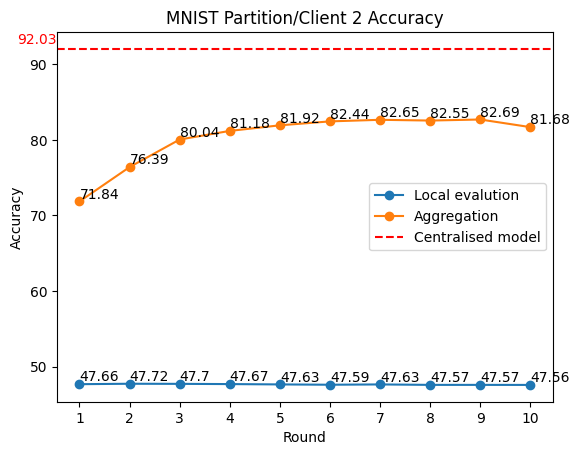

In [18]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"MNIST Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.legend()
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')

average_value = 92.03
plt.gca().text(0, average_value/95, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.show()